# Generate plot for July 30 showing the efect of moment delta mapping on the quantile function.

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
##mtplt.use("TkCairo")
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_data_array(filename, recalculate=False):
    """
    Fetches an xarray data array from a zarr file. Recalculates if the file doesn't exist or if recalculate is True.

    Parameters:
    -----------
    filename: str
        The path to the zarr file.
    recalculate: bool
        If True, recalculate the data array. If False (default), load the data array from the file if it exists.

    Returns:
    --------
    xr.DataArray
        The data array.
    """

    if recalculate or not zarr.is_zarr(filename):
        # Recalculate the data array
        # TODO: replace this with your own code to calculate the data array
        data_array = xr.DataArray([[1, 2], [3, 4]], dims=('x', 'y'))
        
        # Save the data array to the zarr file
        data_array.to_dataset(name='data_array').to_zarr(filename)
    else:
        # Load the data array from the zarr file
        data_array = xr.open_zarr(filename)['data_array']

    return data_array

In [3]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

def detrend_all(ds, central_year):
    # Assumes that the ds has coordinates day, year and member.
    
    #Fit a linear fuction and extract slope
    pcoeffs = ds.mean('member').polyfit(dim='year',deg=1)
    slope   = pcoeffs.polyfit_coefficients.sel(degree=1)
    
    #Calculate trend
    ds_trend   = slope*(ds['year']- central_year)
    
    #Detrend by subtracting the trend from the data
    ds_detrended = ds  - ds_trend
    
    return ds_detrended

In [4]:
def stacker(x,stackdim_name):
    #Assumes that x has dimensions year and member
    #x = x.stack(stackdim_name=('year','member'),create_index=False)
    x = x.stack({stackdim_name: ('year', 'member')},create_index=False)
    return x

In [5]:
def stack_roll(ds,roll_len,stride_len,stackdim_name):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds,stackdim_name)
    #print(ds_stack)
    ds_roll    = ds_stack.rolling({stackdim_name:roll_len}, center=True).construct('index', stride=stride_len)
    
    return ds_roll 

In [6]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='myear')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='myear'))*(ds_sroll/ds_stack.std(dim='myear'))\
          + ds_mroll
    return ds

In [7]:
def gauss_quantile(mean,std,quantile):
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [8]:
# #Chicago
LAT        = 41.8781
LON        = (360-87.6298)%360
# # #Bengaluru:
# LAT        = 12.9716
# LON        = 77.5946
######################
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals_det  = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
loc        = 'Chicago/'
locn       = 'Chicago'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
###########
print('(lat,lon)=',LAT,LON)

(lat,lon)= 41.8781 272.3702


In [9]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39337 instead
  warnings.warn(


In [10]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [11]:
cluster

Dashboard: http://10.0.39.1:39337/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.1:46561,Workers: 0
Dashboard: http://10.0.39.1:39337/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
# eoc_year = 2085 #Central year used for detrending
ic_year  = 2086 #This is the correct yeatr of rolling window operation to work
doy      = 211 # day_of_year
date     = 'Jul30'

In [13]:
#To reduce communication between workers, I am manually fusing tasks
#dask.optimization.fuse(ave_width=50)

In [14]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 5.86 s, sys: 821 ms, total: 6.68 s
Wall time: 7.06 s


In [15]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgpi   = ds_hist.TREFHTMX.sel(method='nearest',time=ds_hist.time.dt.dayofyear==doy).\
         sel(time=slice(pi_year0,pi_year1))
tgeoc  = ds_ssp.TREFHTMX.sel(method='nearest',time=ds_ssp.time.dt.dayofyear==doy).\
         sel(time=slice(ic_year0,ic_year1))

CPU times: user 1.54 s, sys: 44.8 ms, total: 1.59 s
Wall time: 1.59 s


### Get detrended data 

In [16]:
%%time
tdpi_det   = xr.open_zarr(cvals_det+'pi_detrended.zarr').detrended_tmax
tdeoc_det = xr.open_zarr(cvals_det+'eoc_detrended.zarr').detrended_tmax
#
tgpi_det  = tdpi_det.sel(dayofyear=doy)
tgeoc_det = tdeoc_det.sel(dayofyear=doy)
tgeoc_det

CPU times: user 562 ms, sys: 273 ms, total: 834 ms
Wall time: 947 ms


<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100, year: 30)>
dask.array<getitem, shape=(192, 288, 100, 30), dtype=float64, chunksize=(8, 60, 100, 30), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 211
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

### Aggregate data using rolling window and compute quantile functions

In [17]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants  = np.arange(0,1.01,0.01)
########################
N_mem       = 100 
window_len  = 30
#### July 30 #######
tgpi_detroll     = stack_roll(tgpi_det,N_mem*window_len,N_mem,stackdim_name='ym')
tgeoc_detroll    = stack_roll(tgeoc_det,N_mem*window_len,N_mem,stackdim_name='ym')
#########
tgpi_detroll0    = tgpi_detroll.sel(ym=[15])  
tgeoc_detroll0   = tgeoc_detroll.sel(ym=[15])  
tgeoc_detroll0

CPU times: user 256 ms, sys: 17.3 ms, total: 273 ms
Wall time: 270 ms


<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, ym: 1, index: 3000)>
dask.array<getitem, shape=(192, 288, 1, 3000), dtype=float64, chunksize=(8, 60, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 211
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     (ym) int64 0
    year       (ym) int64 2086
Dimensions without coordinates: ym, index

In [18]:
%%time
############# Save files ########################
tgeoc_detrollpath  = cvals_det + 'tgeoc_detrended_roll' +date+'_'+pi_year0+'_'+pi_year1+'.zarr'
# Save eoc detrended rolled array
tgeoc_detroll0     =  tgeoc_detroll0.rename('eoc_detrended_roll')\
                  .chunk({'lat':8}).assign_coords(ym=('ym',[ic_year]))
# tgeoc_detroll0.to_dataset().to_zarr(tgeoc_detrollpath,mode='w')

CPU times: user 21.2 s, sys: 1.09 s, total: 22.3 s
Wall time: 32 s


In [19]:
%%time
#Compute the pre-industrial + moments adjusted curves
#First compute rolling means and stdevs and save them
#Open
tgeoc_detroll   = xr.open_zarr(tgeoc_detrollpath).eoc_detrended_roll
tgeoc_det_mroll = tgeoc_detroll.mean(dim='index')
tgeoc_det_sroll = tgeoc_detroll.std(dim='index')
#############
tgeoc_det_mroll

CPU times: user 274 ms, sys: 20.9 ms, total: 294 ms
Wall time: 281 ms


<xarray.DataArray 'eoc_detrended_roll' (lat: 192, lon: 288, ym: 1)>
dask.array<mean_agg-aggregate, shape=(192, 288, 1), dtype=float64, chunksize=(8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 ...
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year       (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym         (ym) int64 2086

In [20]:
#Now prepare the pre-industrial data array in order to apply the moment delta mapping transformations
###Add a dummy dimension called 'ym' to tgpi_detrended after stacking year and member as 'myear'
############ det ###########
tgpi_det_stack = stacker(tgpi_det,'myear')
###################################
tgpi_det_stack0= tgpi_det_stack.expand_dims(dim={'ym':1}).\
                 assign_coords(ym=('ym',[ic_year]))
tgpi_det_stack0

<xarray.DataArray 'detrended_tmax' (ym: 1, lat: 192, lon: 288, myear: 3000)>
dask.array<broadcast_to, shape=(1, 192, 288, 3000), dtype=float64, chunksize=(1, 8, 60, 1000), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 211
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     (myear) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
    year       (myear) int64 1850 1850 1850 1850 1850 ... 1879 1879 1879 1879
  * ym         (ym) int64 2086
Dimensions without coordinates: myear

In [21]:
%%time
#############
tgmc_det  = mean_adj(tgpi_det_stack0, tgeoc_det_mroll)
tgmsc_det = mean_std_adj(tgpi_det_stack0, tgeoc_det_mroll,tgeoc_det_sroll)
tgmc_det

CPU times: user 1.47 s, sys: 97.9 ms, total: 1.57 s
Wall time: 1.74 s


<xarray.DataArray (ym: 1, lat: 192, lon: 288, myear: 3000)>
dask.array<add, shape=(1, 192, 288, 3000), dtype=float64, chunksize=(1, 8, 60, 1000), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 211
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ym         (ym) int64 2086
Dimensions without coordinates: myear

In [22]:
%%time
#### Compute quantiles 
quants       = np.arange(0,1.01,0.01)
qgmc_det     = tgmc_det.chunk(dict(myear=-1)).quantile(quants,dim='myear',skipna=False)
qgmsc_det    = tgmsc_det.chunk(dict(myear=-1)).quantile(quants,dim='myear',skipna=False)
qgmc_det

CPU times: user 175 ms, sys: 10 ms, total: 185 ms
Wall time: 180 ms


<xarray.DataArray (quantile: 101, ym: 1, lat: 192, lon: 288)>
dask.array<transpose, shape=(101, 1, 192, 288), dtype=float64, chunksize=(101, 1, 8, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ym        (ym) int64 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [23]:
%%time
qgmsc_detpath = cvals_det+'qgmsc_percentile_det'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_detpath  = cvals_det+'qgmc_percentile_det'+date+'_' +ic_year0+'_'+ic_year1+'.zarr'
##################### Save #####################
qgmc_det       = qgmc_det.rename('qgmc_detrended').chunk({'lat':8})
qgmsc_det      = qgmsc_det.rename('qgmsc_detrended').chunk({'lat':8})
#
# qgmc_det.to_dataset().to_zarr(qgmc_detpath,mode='w') 
# qgmsc_det.to_dataset().to_zarr(qgmsc_detpath,mode='w')

CPU times: user 1min 4s, sys: 2.63 s, total: 1min 7s
Wall time: 1min 10s


In [24]:
qgmc_det  = xr.open_zarr(qgmc_detpath).qgmc_detrended
qgmsc_det = xr.open_zarr(qgmsc_detpath).qgmsc_detrended

In [25]:
########## EOC gaussians ###########
tgeoc_det_mroll0 = tgeoc_det_mroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
tgeoc_det_sroll0 = tgeoc_det_sroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
# Create a DataArray for the quantiles
quantiles = xr.DataArray(np.arange(0, 1.01, 0.01), dims='quantile').\
assign_coords(quantile=('quantile',quants))
####### Construct gaussians for model warming ################
qg        = xr.apply_ufunc(erfinv,2*quantiles-1)
#################
qgauss_det      = tgeoc_det_mroll0 + tgeoc_det_sroll0 * np.sqrt(2) *qg
qgauss_det.name = 'gauss_detrended'
qgauss_det

<xarray.DataArray 'gauss_detrended' (quantile: 101, lat: 192, lon: 288, ym: 1)>
dask.array<add, shape=(101, 192, 288, 1), dtype=float64, chunksize=(101, 8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    dayofyear  int64 211
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year       (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym         (ym) int64 2086
  * quantile   (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [26]:
qgeoc_det = tgeoc_detroll0.chunk(dict(index=-1)).quantile(quants,dim='index',skipna=False)
qgeoc_det

<xarray.DataArray 'eoc_detrended_roll' (quantile: 101, lat: 192, lon: 288, ym: 1)>
dask.array<transpose, shape=(101, 192, 288, 1), dtype=float64, chunksize=(101, 8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year      (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym        (ym) int64 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

### MDM Errors in prediction for EOC 

In [28]:
%%time
qgmsc_det_err  = qgmsc_det.sel(ym=ic_year)  - qgeoc_det.sel(ym=ic_year)
qgmc_det_err   = qgmc_det.sel(ym=ic_year)   - qgeoc_det.sel(ym=ic_year)
qgauss_det_err = qgauss_det.sel(ym=ic_year) - qgeoc_det.sel(ym=ic_year)
qgmsc_det_err 

CPU times: user 1.86 s, sys: 84.2 ms, total: 1.94 s
Wall time: 2.2 s


<xarray.DataArray (quantile: 101, lat: 192, lon: 288)>
dask.array<sub, shape=(101, 192, 288), dtype=float64, chunksize=(101, 8, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 2086
    ym        int64 2086

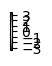

In [29]:
######## New colorbar only for shift + stretch and gaussian ############
x = 3.5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

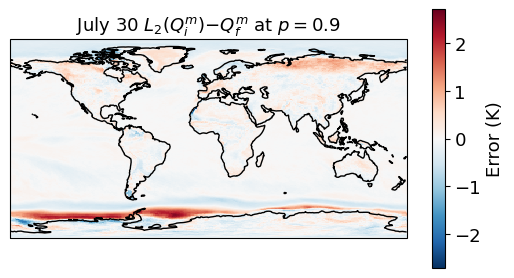

CPU times: user 40.9 s, sys: 1.99 s, total: 42.9 s
Wall time: 49.7 s


In [31]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
im = qgmsc_det_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree()
                                      ,add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.plot(-87.629,41.94,marker='*',color='tab:orange')
#plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(r'July 30 $L_2(Q^m_i) − Q^m_f$ at $p = 0.9$',fontsize=13)
#
# Adding colorbar
cbar = plt.colorbar(im,ax=ax, shrink=0.7, orientation='vertical')
cbar.set_label('Error (K)',fontsize=13)
cbar.ax.tick_params(labelsize=13) 
plt.show()

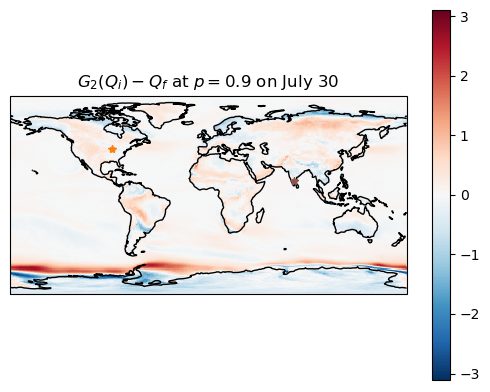

CPU times: user 44.9 s, sys: 1.94 s, total: 46.8 s
Wall time: 52.9 s


In [32]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgauss_det_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree())
                                      #,add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(r'$G_2(Q_i) - Q_f$ at $p=0.9$ on July 30')
plt.show()

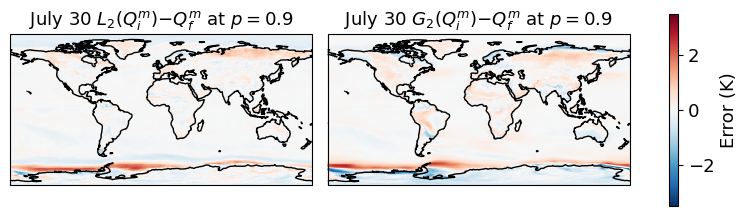

CPU times: user 1min 26s, sys: 4.3 s, total: 1min 30s
Wall time: 1min 44s


In [33]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qgmsc_det_err.sel(quantile=0.9).plot(ax=axs[0], transform=cart.crs.PlateCarree(),add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
#axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_title(r'July 30 $L_2(Q^m_i) − Q^m_f$ at $p = 0.9$',fontsize=13)

# Plotting da2
im = qgauss_det_err.sel(quantile=0.9).plot(ax=axs[1], transform=cart.crs.PlateCarree(), add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
#axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_title(r'July 30 $G_2(Q^m_i) − Q^m_f$ at $p = 0.9$',fontsize=13)

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Error (K)',fontsize=13)
cbar.ax.tick_params(labelsize=13)  

#plt.tight_layout()
plt.show()